In [17]:
from pathlib import Path
from PIL import Image

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Project root = parent of "notebooks"
PROJECT_ROOT = Path("..").resolve()

DATA_DIR = PROJECT_ROOT / "data" / "raw_images"

anno_path = DATA_DIR / "boxes" / "oidv6-train-annotations-bbox.csv"
classes_path = DATA_DIR / "metadata" / "class-descriptions-boxable.csv"

# Load CSVs
bbox_df = pd.read_csv(anno_path)
classes_df = pd.read_csv(classes_path, names=["label_id", "label_name"])

# Person class ID
person_id = classes_df.loc[classes_df["label_name"] == "Person", "label_id"].iloc[0]
person_id

'/m/01g317'

In [19]:
# Filter bounding boxes for Person only
person_boxes = bbox_df[bbox_df["LabelName"] == person_id]

# Count how many boxes per image
counts = person_boxes["ImageID"].value_counts()

# Keep only images with exactly ONE person
single_person_ids = counts[counts == 1].index.tolist()

len(single_person_ids)


102442

In [20]:
IMG_DIR = DATA_DIR / "train" / "person"

# Build full paths
image_paths = []
for img_id in single_person_ids:
    img_path = IMG_DIR / f"{img_id}.jpg"
    if img_path.exists():
        image_paths.append(img_path)

len(image_paths)


1992

In [21]:
print("requested IDs:", len(single_person_ids))
print("found files:", len(image_paths))
print("missing count:", len(single_person_ids) - len(image_paths))

requested IDs: 102442
found files: 1992
missing count: 100450


In [22]:

IMG_DIR = Path("..") / "data" / "raw_images" / "train" / "person"
downloaded_ids = {p.stem for p in IMG_DIR.glob("*.jpg")}
len(downloaded_ids)

5000

In [23]:
# 2.1: Filter to Person label only
person_boxes = bbox_df[bbox_df["LabelName"] == person_id]

# 2.2: Keep only boxes for images we have locally
filtered_boxes = person_boxes[person_boxes["ImageID"].isin(downloaded_ids)]
len(filtered_boxes), filtered_boxes["ImageID"].nunique()



(20900, 5000)

In [24]:
# Count how many person boxes per ImageID
counts = filtered_boxes["ImageID"].value_counts()

# Only keep images with exactly one person
single_person_ids = counts[counts == 1].index.tolist()
len(single_person_ids)


1992

In [25]:

# Adjust folder name if it's "Person" instead of "person"
IMG_DIR = Path("..") / "data" / "raw_images" / "train" / "person"

records = []

for img_id in single_person_ids:
    row = filtered_boxes[filtered_boxes["ImageID"] == img_id].iloc[0]
    img_path = IMG_DIR / f"{img_id}.jpg"
    if not img_path.exists():
        continue  # skip if file missing (just in case)

    records.append({
        "image_id": img_id,
        "image_path": str(img_path),
        "XMin": row["XMin"],
        "XMax": row["XMax"],
        "YMin": row["YMin"],
        "YMax": row["YMax"],
    })

clean_df = pd.DataFrame(records)
len(clean_df), clean_df.head()


(1992,
            image_id                                         image_path  \
 0  03824eac0cc9293f  ../data/raw_images/train/person/03824eac0cc929...   
 1  00cb2903a338b1ed  ../data/raw_images/train/person/00cb2903a338b1...   
 2  03df3dd775f4da95  ../data/raw_images/train/person/03df3dd775f4da...   
 3  038259d823c904fa  ../data/raw_images/train/person/038259d823c904...   
 4  03df2f11c8dc6c6f  ../data/raw_images/train/person/03df2f11c8dc6c...   
 
        XMin      XMax      YMin      YMax  
 0  0.597500  0.787500  0.464167  0.666667  
 1  0.175000  0.936875  0.115000  1.000000  
 2  0.341912  0.712010  0.098856  0.756536  
 3  0.160625  0.953750  0.229462  0.999056  
 4  0.343750  0.400000  0.719745  0.823248  )

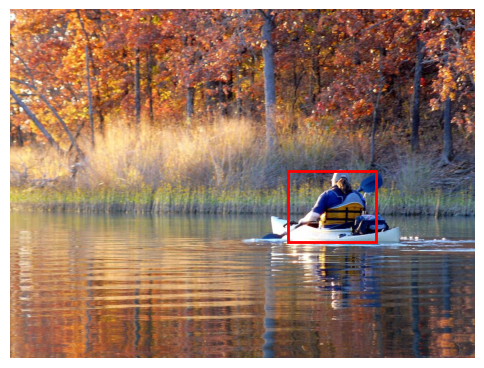

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def show_bbox(image_path, xmin, xmax, ymin, ymax):
    img = Image.open(image_path)
    w, h = img.size

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img)

    # convert normalized coords to pixels
    x_abs = xmin * w
    y_abs = ymin * h
    box_w = (xmax - xmin) * w
    box_h = (ymax - ymin) * h

    rect = patches.Rectangle(
        (x_abs, y_abs),
        box_w,
        box_h,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.axis("off")
    plt.show()


# Try with first example
sample = clean_df.iloc[0]
show_bbox(sample.image_path, sample.XMin, sample.XMax, sample.YMin, sample.YMax)


In [27]:
PROCESSED_DIR = Path("..") / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

out_path = PROCESSED_DIR / "person_clean_dataset.csv"
clean_df.to_csv(out_path, index=False)
out_path


PosixPath('../data/processed/person_clean_dataset.csv')

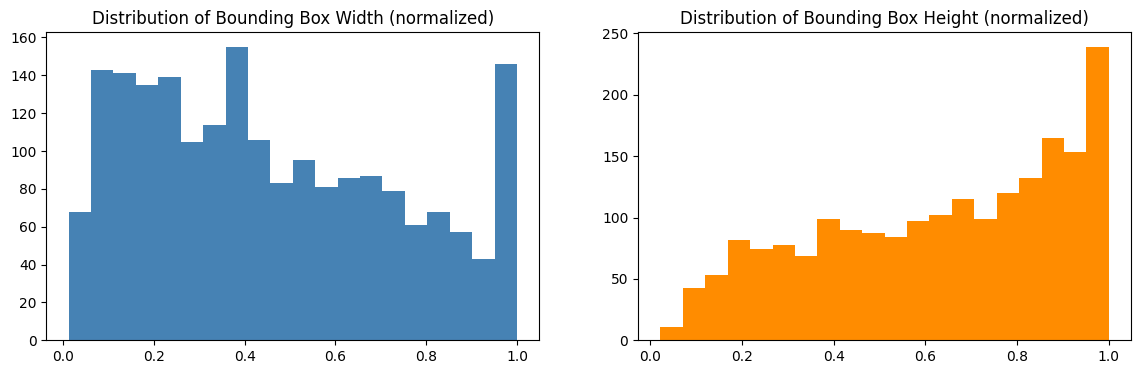

In [28]:
clean_df["bbox_width"] = clean_df["XMax"] - clean_df["XMin"]
clean_df["bbox_height"] = clean_df["YMax"] - clean_df["YMin"]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(clean_df["bbox_width"], bins=20, color="steelblue")
plt.title("Distribution of Bounding Box Width (normalized)")

plt.subplot(1,2,2)
plt.hist(clean_df["bbox_height"], bins=20, color="darkorange")
plt.title("Distribution of Bounding Box Height (normalized)")
plt.show()


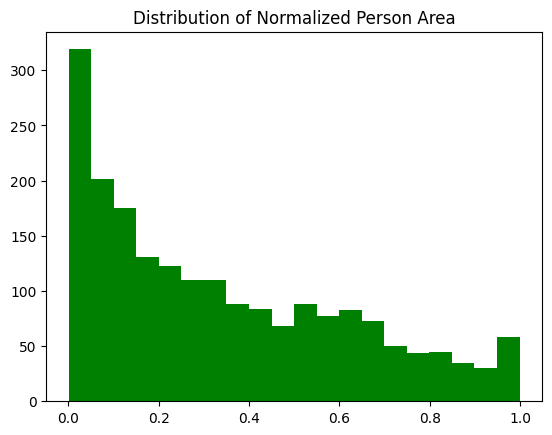

In [29]:
clean_df["bbox_area"] = clean_df["bbox_width"] * clean_df["bbox_height"]

plt.hist(clean_df["bbox_area"], bins=20, color="green")
plt.title("Distribution of Normalized Person Area")
plt.show()


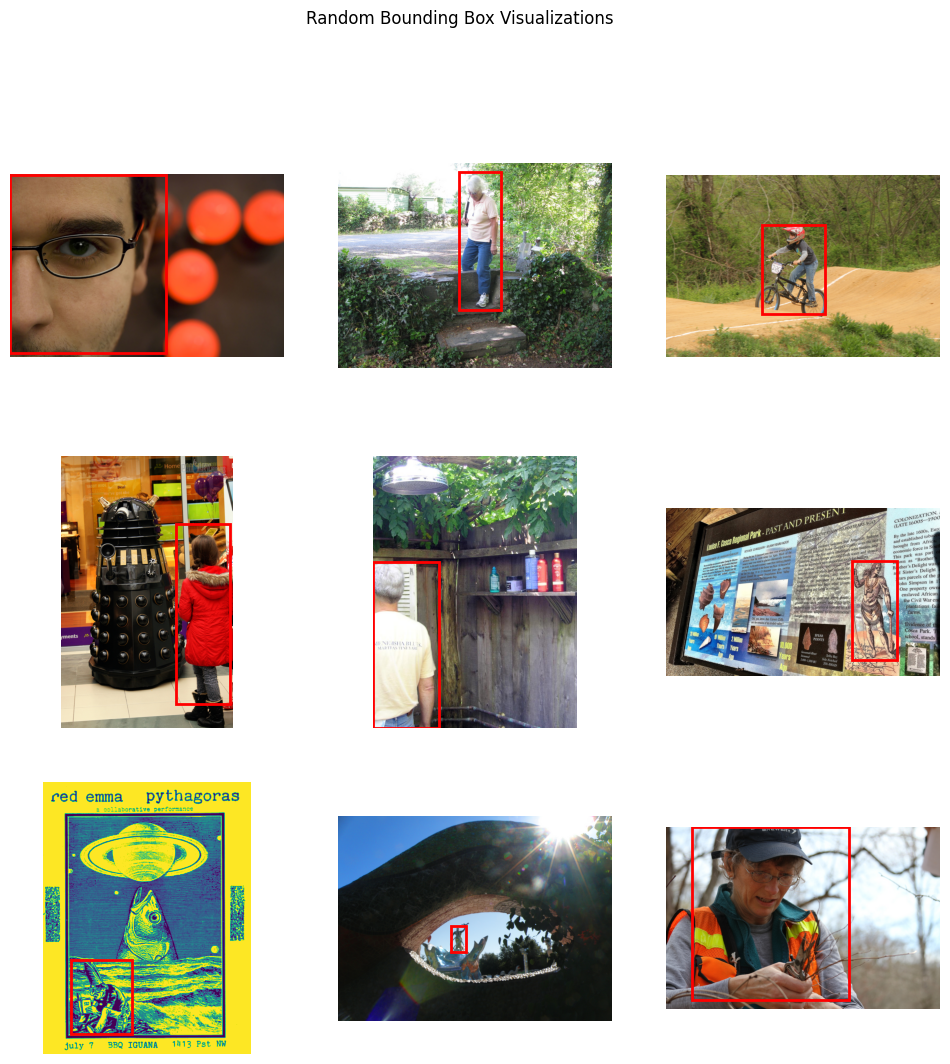

In [30]:
import random

plt.figure(figsize=(12, 12))

for i in range(9):
    idx = random.randint(0, len(clean_df)-1)
    row = clean_df.iloc[idx]
    img = Image.open(row.image_path)
    w, h = img.size

    xmin, xmax = row.XMin * w, row.XMax * w
    ymin, ymax = row.YMin * h, row.YMax * h

    plt.subplot(3, 3, i+1)
    plt.imshow(img)

    plt.gca().add_patch(
        patches.Rectangle(
            (xmin, ymin),
            xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor="red", facecolor="none"
        )
    )
    plt.axis("off")

plt.suptitle("Random Bounding Box Visualizations")
plt.show()


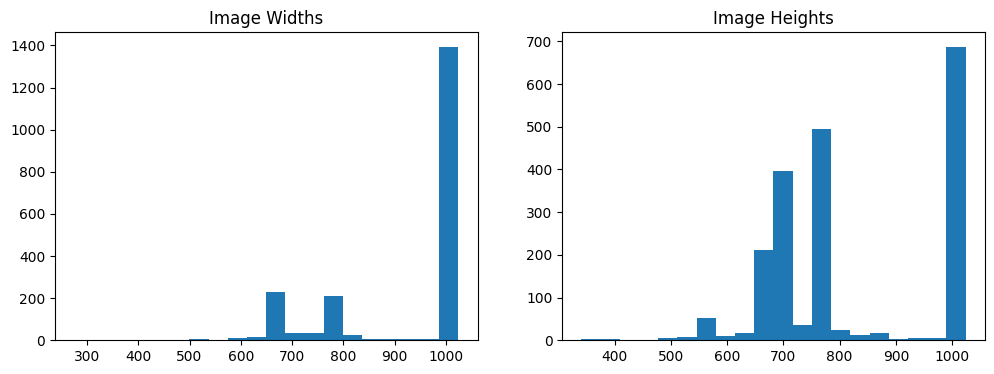

In [31]:
widths = []
heights = []

for p in clean_df["image_path"]:
    img = Image.open(p)
    w, h = img.size
    widths.append(w)
    heights.append(h)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20)
plt.title("Image Widths")

plt.subplot(1,2,2)
plt.hist(heights, bins=20)
plt.title("Image Heights")
plt.show()


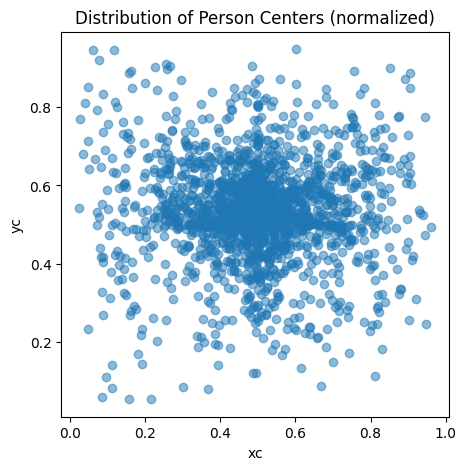

In [32]:
clean_df["xc"] = (clean_df["XMin"] + clean_df["XMax"]) / 2
clean_df["yc"] = (clean_df["YMin"] + clean_df["YMax"]) / 2

plt.figure(figsize=(5,5))
plt.scatter(clean_df["xc"], clean_df["yc"], alpha=0.5)
plt.title("Distribution of Person Centers (normalized)")
plt.xlabel("xc")
plt.ylabel("yc")
plt.show()
